# WHAT DO YOU WANNA DO WITH YOUR ~~LIFE~~ PROJECT?!

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import re
import os
from datetime import date
import mygene         #for alternative method of changing ensembl names to gene symbols
mg = mygene.MyGeneInfo()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from porch import porch
from urllib.error import HTTPError, URLError
import time
import sys

/home/augjan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [206]:
def drop(df, col, key):
    '''
    Fuction to make it possible to drop rows of a dataframe (df) with a specific list as condition (key) in a specific column (col)
    '''
    m = [v == key for v in df[col]]
    df.loc[m, col] = float('NaN')
    df.dropna(inplace=True)
    return df

def TFs_targets(kbp, chip, MACS2, MAX): 
    '''
    Function for creating csv with all TFs and their target genes. For each TF, it identifies urls for target gene data, fetches the info and puts it into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set =  pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)-2):
                    col[i+1] = col[i+1].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1

    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

    return TF_gene_sets

def TFs_targets_strict_porch(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = str(TF_gene_set.loc[(TF_gene_set > 700).sum(axis=1)>0,:].reset_index()['Target_genes'].tolist()).replace("'","") #['Target_genes'] #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets = drop(TF_gene_sets, 'Genes', '[]')
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets

def Bigdict(kbp):
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')
    
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    bigdict = {}
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                bigdict[chip.index[dex]] = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                bigdict[chip.index[dex]] = pd.DataFrame()
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    return bigdict
    
def TF_targets_dict(bigdict, MACS2, MAX, kbp):
    TF_gene_list = []

    for TF in bigdict: #OBS! This takes a long time.
        TF_gene_set = bigdict[TF].copy()
        col = list(TF_gene_set.columns)
        for i in range(len(col)-2):
            col[i+1] = col[i+1].split('|',1)[1]
        TF_gene_set.columns = col
        TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
        for sample in TF_set.columns:
            TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
        TF_set['Max'] = TF_set.max(axis=1)
        genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
        TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=bigdict.keys()) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.index.name = 'Antigen'  
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes.astype(str) == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

def ID_to_symbol(datatsv): 
    '''
    Function for replacing the ensenbl gene IDs with gene symbols/names in dataframe with expression data
    '''
    dataset = pd.read_csv(datatsv, sep='\t') 
    symbols = pd.read_csv('../data/Gene_names.txt', index_col='Gene stable ID')
    symbols = symbols.drop_duplicates(keep=False)
    dataset = dataset.merge(symbols, left_on='Gene', right_on='Gene stable ID', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('Gene name', inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.index.rename('Symbol', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t')
    return dataset

def ID_to_symbolMG(datatsv):
    '''
    Alternative function for replacing the ensembl gene IDs with gene symbols/names in expression data, using MyGene package.
    '''
    dataset = pd.read_csv(datatsv, sep='\t')
    genes = dataset.loc[:,'Gene']
    genesyms = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', as_dataframe=True) #Look up gene symbols with mygene
    genesyms = genesyms.dropna(subset=['symbol'], how='any') #Drop genes where no gene symbol was identified
    genesyms = genesyms.loc[~genesyms.index.duplicated(keep=False)] #Drop genes for which multiple gene symbols were identified
    syms = genesyms.loc[:,'symbol']
    dataset = dataset.merge(syms, left_on='Gene', right_on='query', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('symbol', inplace=True)
    dataset.index.rename('Symbol',inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbolsMG.tsv', sep='\t')
    return dataset

def csv_fix(csv):
    '''
    Function that opens a csv file and removes quotes at the end and beginning of rows with quotes in them,
    and converst double quotes to single quotes.
    (The original chip_atlas_analysis_list.csv that was downloaded did not work,
    as it contained an extra '"' in the start and end of each row with '"' in it, and each '"' had an extra  '"')
    '''
    name, ext = os.path.splitext(csv)
    newfilename = '{name}_{add}{ext}'.format(name=name, add='CORRECTED', ext='.csv')
    with open(csv,'r+') as csv_file:
        for line in csv_file:
            # removing starting and ending quotes of a line
            pattern1 = re.compile(r'^"|"$',re.MULTILINE)
            line = re.sub(r'^"|"$',"",line)
            # substituting escaped quote with a single quote
            pattern2 = re.compile(r'""')
            line = re.sub(r'""','"',line)
            corrected_csv = open(newfilename,'a')
            corrected_csv.write(line)
            corrected_csv.close()
    csv_df = pd.read_csv(newfilename, quotechar = '"')
    return csv_df

def gene_sets(kbp, MACS2, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets(kbp,chip,MACS2,MAX)
        
    return TF_gene_sets

    
def gene_sets_porch(kbp, MACS2):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t', index_col='Antigen')
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_strict_porch(kbp, MACS2, chip)
        
    #Pick out gene sets with 500 or fewer genes
    TF_short_sets = TF_gene_sets.copy()
    for TF in TF_short_sets.index:
        if len(TF_short_sets.loc[TF,:][0]) > 500:
            TF_short_sets.drop([TF], inplace=True)
    return TF_gene_sets

def data_set():
    '''
    Fetch the longitudinal mRNA expression data and the sample specifications
    '''
    #Read in dataset with expression values and gene symbols. If not available, replace ensembl IDs and create the csv
    try:
        dataset = pd.read_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t', index_col='Symbol')
    except:
        ID_to_symbol('../data/genes.raw.htseq2.tsv')

    #Read in dataset with sample sepcifications
    dataset2 = pd.read_csv('../data/E-MTAB-2328.sdrf.tsv', sep='\t') #Read csv with specifications of assays
    return dataset, dataset2

def indexing(dataset, dataset2):
    '''
    Function that creates a dataframe with multi-colunindex of organ and developmental stage, index is genes
    '''
    #Exctract important characteristincs of samples from dataset2
    chars = pd.DataFrame()
    chars['assay'] = dataset2.loc[:,'Assay Name'].str.slice(stop=6)
    #chars['dev_stage'] = dataset2.loc[:,'Characteristics[developmental stage]']
    chars['organ'] = dataset2.loc[:,'Characteristics[organism part]']
    chars = chars.drop_duplicates()
    chars['dev_stage'] = [-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29,-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29]
    chars = chars.set_index('assay')

    #Insert the important characteristics into dataset with expression values as column index
    datasetT = dataset.T
    datasetT['dev_stage'] = datasetT.index.to_series().map(chars['dev_stage'])
    datasetT['organ'] = datasetT.index.to_series().map(chars['organ'])
    datasetT.set_index(['organ','dev_stage'], inplace=True)
    #expdata = datasetT.sort_index(level = 0).T
    expdata = datasetT.T
    return expdata

def my_pca(df, n_pc=1, normalize=True):
    '''
    Function for performing the PCA, using sklearn. 
    
    df - Dataframe with expression values
    '''
    df = df.dropna(axis = 0, how = 'all') #Remove rows with only NA values. Should be none
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if normalize:
        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
    n_pcs = min(df.shape[0],n_pc)
    pca = PCA(n_components = n_pcs) #Set PCA parameters
    pca.fit(x2) #Fit data to model
    expl = pca.explained_variance_ratio_
    x3 = pca.fit_transform(x2) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.transpose(), index=list(range(1,n_pcs+1)), columns=df.columns).T #Create dataframe with vlues from the PCA and set columnindex as the PC number 

    cont = pd.DataFrame(index=df.index)
    for i in range(n_pcs):
        cont.loc[:,'PC{0} contribution'.format(i+1)] = pca.components_[i]**2
    cont.sort_values(by='PC1 contribution', ascending=False, inplace=True)
        
    while n_pcs < n_pc:
        expl = np.append(expl,float('NaN'))
        n_pcs = n_pcs + 1
        out_df.loc[:,str(n_pcs)] = float('NaN')

    return out_df, expl, cont

def run_my_pca(expdata, TF_gene_sets, Other_results, n_pc=1):
    '''
    Function that uses my_pca on supplied dataframe
    '''
    PCA_per_TF = {}
    Contributions = {}
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)] = pd.DataFrame(index=expdata.columns)
    for TF in TF_gene_sets.index: 
        genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
        genesIndex.set_index('Genes', inplace=True)  
        genes = genesIndex.index.intersection(expdata.index)
        TFdata = expdata.loc[genes,:]
        [res, expl, cont] = my_pca(TFdata, n_pc)
        Contributions[TF] = cont
        for i in range(n_pc):
            PCA_per_TF['PC{0}'.format(i+1)][TF] = res.iloc[:,i]
            PCA_per_TF[TF] = res.iloc[:,0]
            Other_results.loc[TF,'Gene count'] = len(genes)
            Other_results.loc[TF,'Variance explained PC'+str(i+1)] = expl[i]
        
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)].sort_index(inplace=True)
    return PCA_per_TF, Other_results, Contributions

def ANOVA(PCA_per_TF, Other_results):
    '''
    Perform two-way ANOVA with statsmodels anova_lm for each TF separately and return a dataframe with p-values
    '''
    for TF in Other_results.index:
        test_data = pd.DataFrame(PCA_per_TF.loc[:,TF])
        test_data = test_data.reset_index()
        test_data.columns = ["organ", "dev_stage", "TF_expr"]
        TF_lm = ols('TF_expr ~ C(organ)+C(dev_stage)+C(organ):C(dev_stage)', data=test_data).fit()
        table = sm.stats.anova_lm(TF_lm, typ=2)
        Other_results.loc[TF,'C(organ)'] = table.iloc[0,3]
        Other_results.loc[TF,'C(dev_stage)'] = table.iloc[1,3]
        Other_results.loc[TF,'C(organ):C(dev_stage)'] = table.iloc[2,3]
    return Other_results

def ANOVAone(PCA_per_TF, Other_results):
    '''
    Perform one-way ANOVA with statsmodels anova_lm for each TF separately and return a dataframe with p-values
    '''
    for TF in Other_results.index:
        test_data = pd.DataFrame(PCA_per_TF.loc[:,TF])
        test_data = test_data.reset_index()
        test_data.columns = ["dev_stage", "TF_expr"]
        TF_lm = ols('TF_expr ~ C(dev_stage)', data=test_data).fit()
        table = sm.stats.anova_lm(TF_lm, typ=2)
        Other_results.loc[TF,'C(dev_stage)'] = table.iloc[0,3]
    return Other_results

def save_exp(data, filename):
    '''
    Save data from performed experiments as tsv file in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    data.to_csv('../exp/'+str(date.today())+'/'+filename+'.tsv', sep='\t')
        
def save_fig(figure, A, B):
    '''
    Save a figure as a png in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    figure.savefig('../exp/'+str(date.today())+'/'+A+'_'+B+'_plot.png', bbox_inches="tight")

def disthist(Other_results):
    '''
    Plot histogram for p-value distribution inlcluding all three tested groups
    '''
    bins = np.linspace(0,1, 51)
    plt.figure(figsize=(16,8))
    for variable in [var for var in Other_results.columns if 'C(' in var]:
        plt.hist(Other_results.loc[:,variable], bins, alpha=0.5, label=variable)
    plt.legend(loc='upper right')
    plt.xlabel('p-value')
    plt.ylabel('Number of TFs')
    plt.title('p-value histogram')
    save_fig(plt,'p-value','histogram')
    plt.show()
    
def lowp(Other_results):    
    '''
    Make and show dataframes with TFs with a p-value below Bonferroni corrected 0.05 for each of the groups tested
    '''
    for var in [var for var in Other_results.columns if 'C(' in var]:
        low_p_vals = Other_results.loc[Other_results[var]<(0.05/len(Other_results))]
        low_p_vals.sort_values(by=var, inplace=True)
    return low_p_vals

def activityplot(TF_list, PCA_results, logdata, organ='', hue=None, style=None):
    '''
    Function for plotting TF principal component and gene expression over time
    '''
    for TF in TF_list.index:
        fig, axes = plt.subplots(1,2, figsize=(32,16)) #, gridspec_kw={'height_ratios': [1,x]})
        #Plot the combined PC expression for TFs in list
        PC_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=PCA_results.reset_index(), ax=axes[0])        
        axes[0].set_xlabel('Developmental stage (days)')
        axes[0].set_ylabel('Log2 expression')
        axes[0].set_title(TF+' PC expression'+organ)
#        save_fig(plt,TF,'PC'+organ)
        #Plot the gene expression for the TFs in list
        Gene_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=logdata.T.sort_index().reset_index(), ax=axes[1])
        axes[1].set_xlabel('Developmental stage (days)')
        axes[1].set_ylabel('Log2 expression')
        axes[1].set_title(TF+' gene expression'+organ)
#        save_fig(plt,TF,'Gene'+organ)
    plt.show()
    
def TF_selection(logdata, TF_gene_sets):
    '''
    Function for selecting TFs with high and varying gene expression for the first test of the method
    '''
    genes = TF_gene_sets.index.intersection(logdata.index)
    logdata = logdata.loc[genes,:]
    mean = logdata.mean().mean()
    for gene in logdata.index:
        if logdata.loc[gene,:].mean()<mean:
            logdata.drop(gene, inplace=True)
        else:
            logdata.loc[gene,'Variance'] = np.var(logdata.loc[gene,:])
    logdata.sort_values(by='Variance', inplace=True)
    genes = logdata.nlargest(n=5, columns='Variance').index.tolist()
    return genes    
    
def main (kbp, MACS2, genelim, organ=None):
    '''
    Main function for running the primary experiment
    '''
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    TF_gene_sets = gene_sets(kbp, MACS2)
    for TF in TF_gene_sets.index:
        if len(TF_gene_sets.loc[TF,:][0])>genelim or len(TF_gene_sets.loc[TF,:][0])<2:
            TF_gene_sets.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    expdata = expdata + 1
    logdata = np.log2(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    #Prepare a dataframe to store all results that are not the PCA values for each sampling point
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    #Run PCA on the prepared dataframe, giving the PC values for each TF and how much of the data the the first PC explains
    [PCA_results, Other_results] = run_my_pca(logdata, TF_gene_sets, Other_results)
    #Perform ANOVA
    if organ == None:
        Other_results = ANOVA(PCA_results, Other_results)
    else:
        Other_results = ANOVAone(PCA_results, Other_results)
    #Plot the p-value distribution for differences between organs, developmental stages, and the combination of the two variables
    disthist(Other_results)
    #Pick out low p-values, based on Bonferroni multiple hypothesis corrected significance threshold of 0.05 
    low_p_vals = lowp(Other_results)
    #Plot the expression over time for TFs with low p-value, both their principal component and own gene expression data
    if organ == None:
        activityplot(low_p_vals, PCA_results, logdata)
    else:
        activityplotsep(low_p_vals, PCA_results, logdata, organ)
    #Save the acquired results as tsv files
    save_exp(PCA_results, 'PCA_results')
    save_exp(Other_results, 'Other_results')
    return PCA_results, Other_results

def main2(kbp, MACS2, MAX, n_pc=1, PC=1, organ=None):
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    
    expdata = expdata + 1
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]

    Gene_plot = sns.lineplot(x='dev_stage', y='Txndc11', data=logdata.T.sort_index().reset_index())

    obvious = TF_selection(logdata,TF_gene_sets)
    Other_results = pd.DataFrame(index=TF_gene_sets.loc[obvious,:].index)
    [PCA_results, Other_results, Contributions] = run_my_pca(logdata,TF_gene_sets.loc[obvious,:],Other_results, n_pc)
    if organ == None:
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,hue='organ',style='organ')
    else:
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,organ=' '+organ)
    for a in Contributions:
        print('Gene contributions for TF {0}:'.format(a))
        display(Contributions[a])
        if 'Txndc11' in Contributions[a].index:
            display(Contributions[a].loc['Txndc11','PC1 contribution'])
    return PCA_results, Other_results, Contributions

/home/augjan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/augjan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


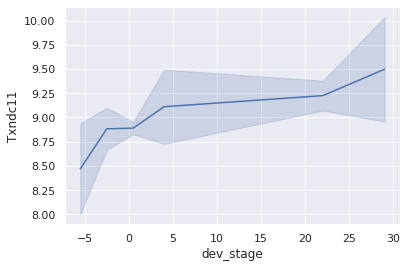

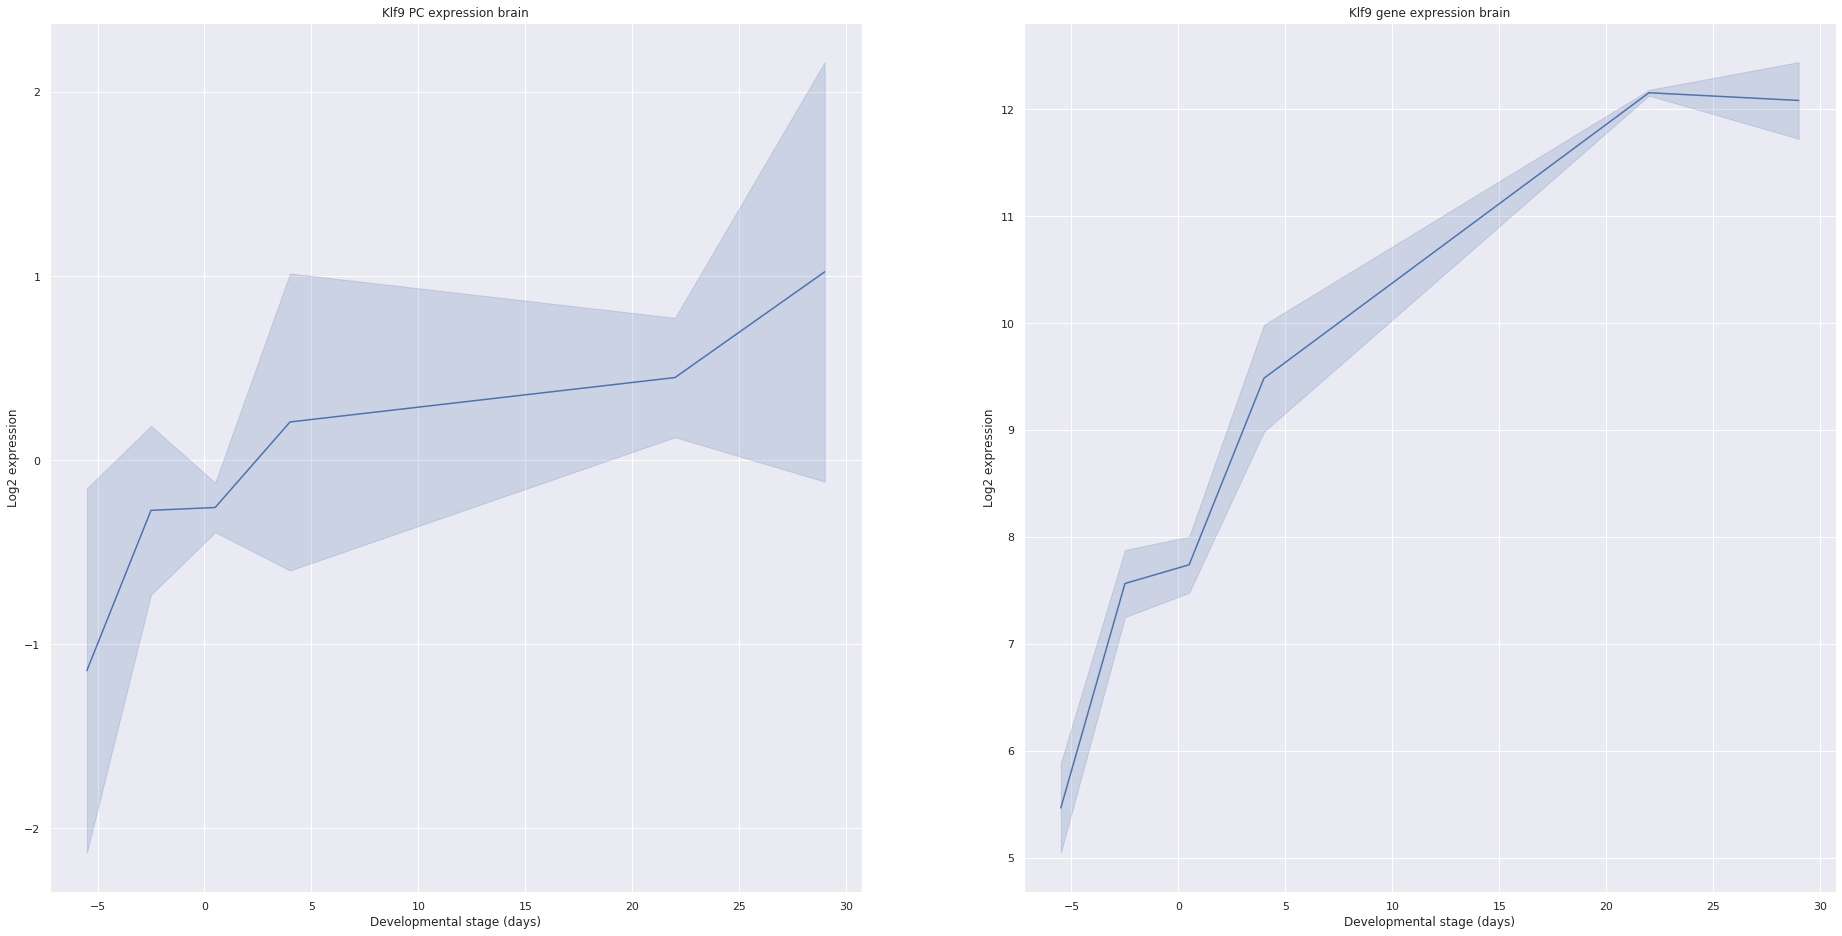

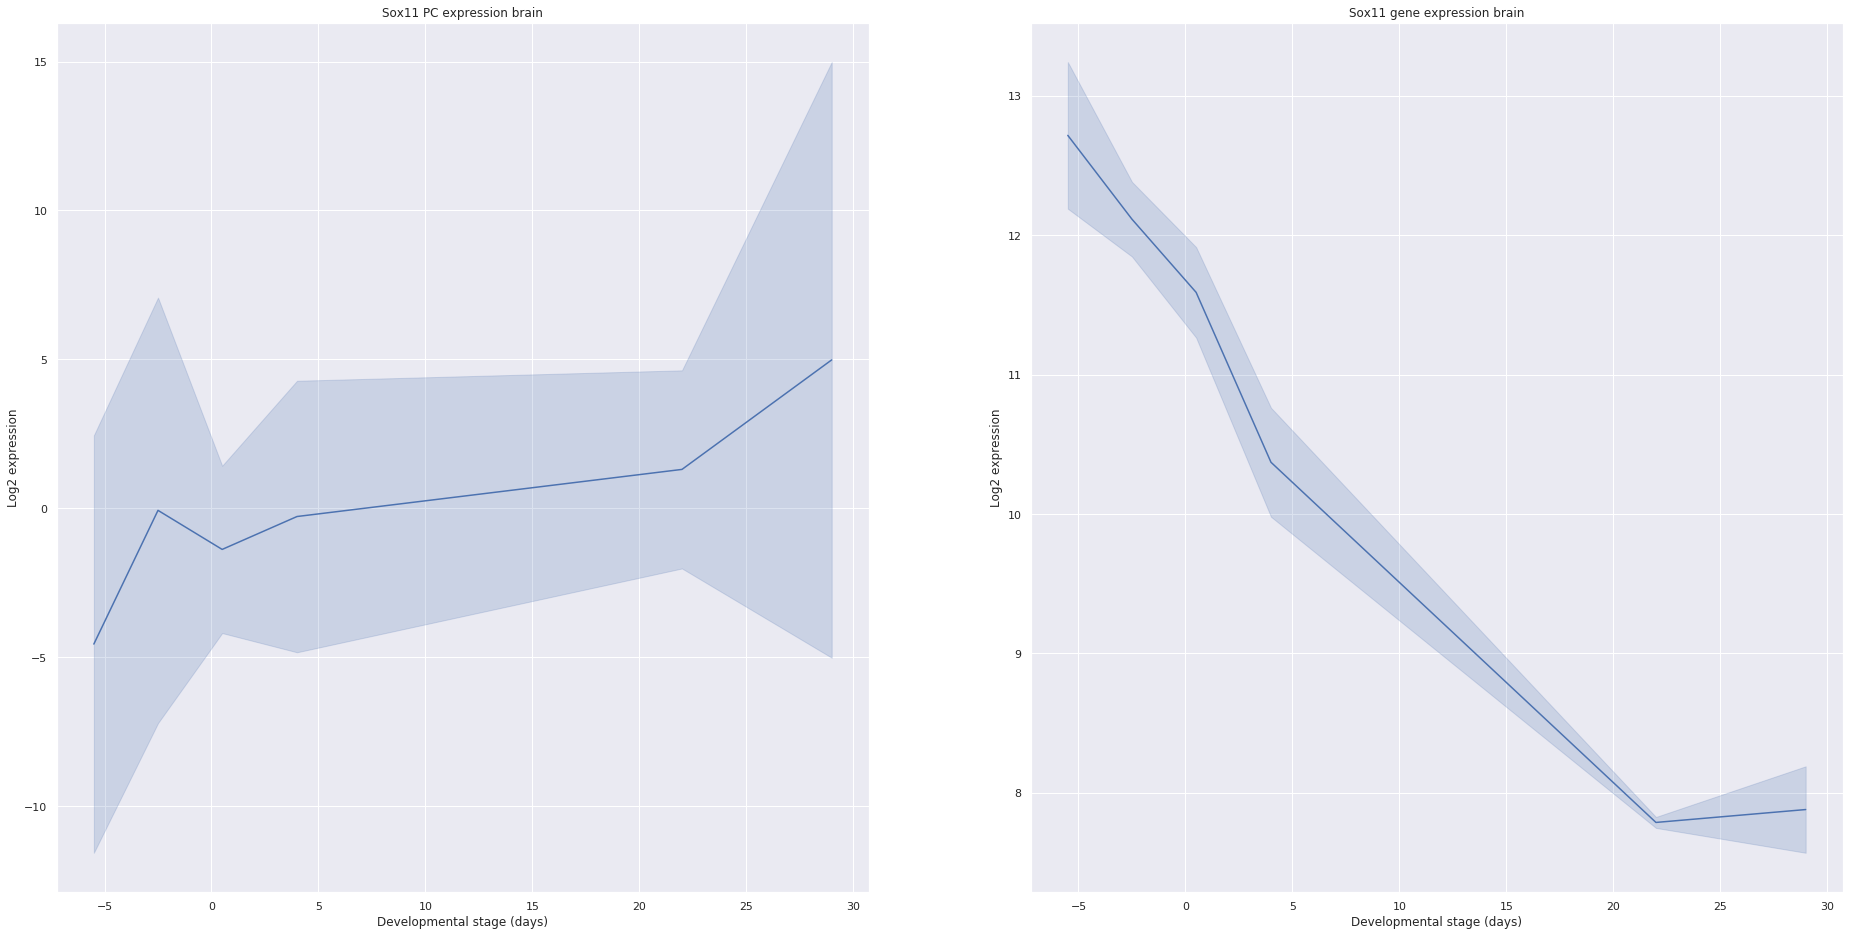

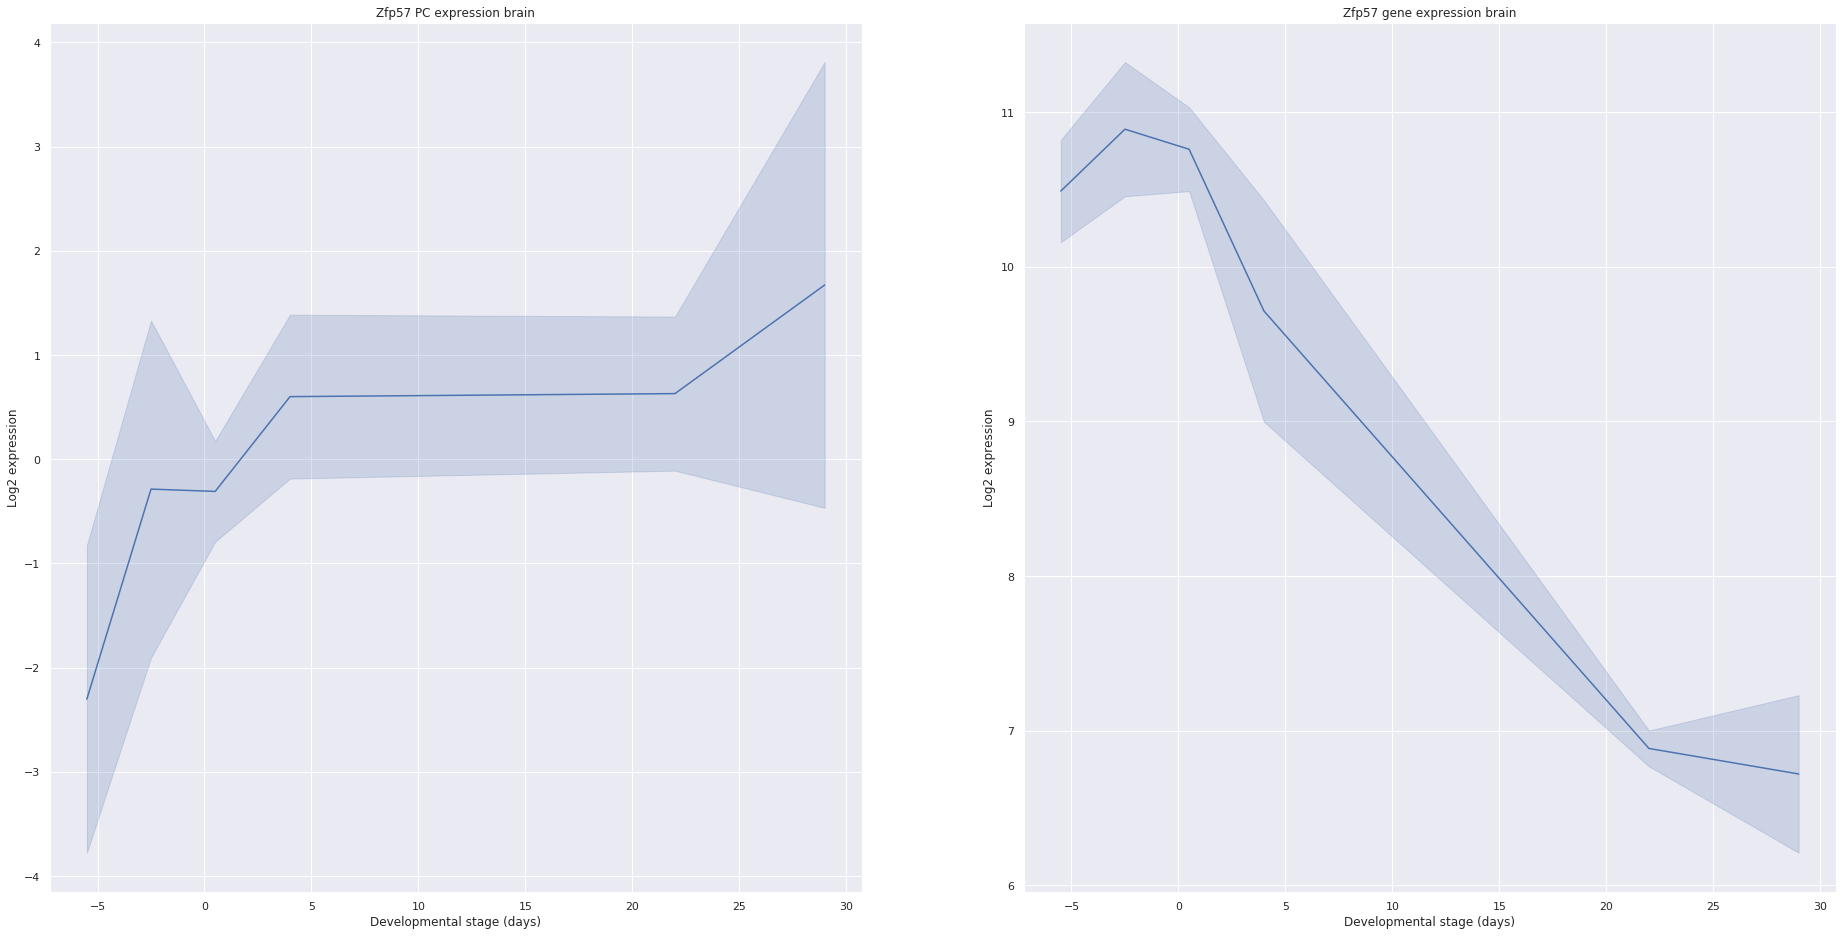

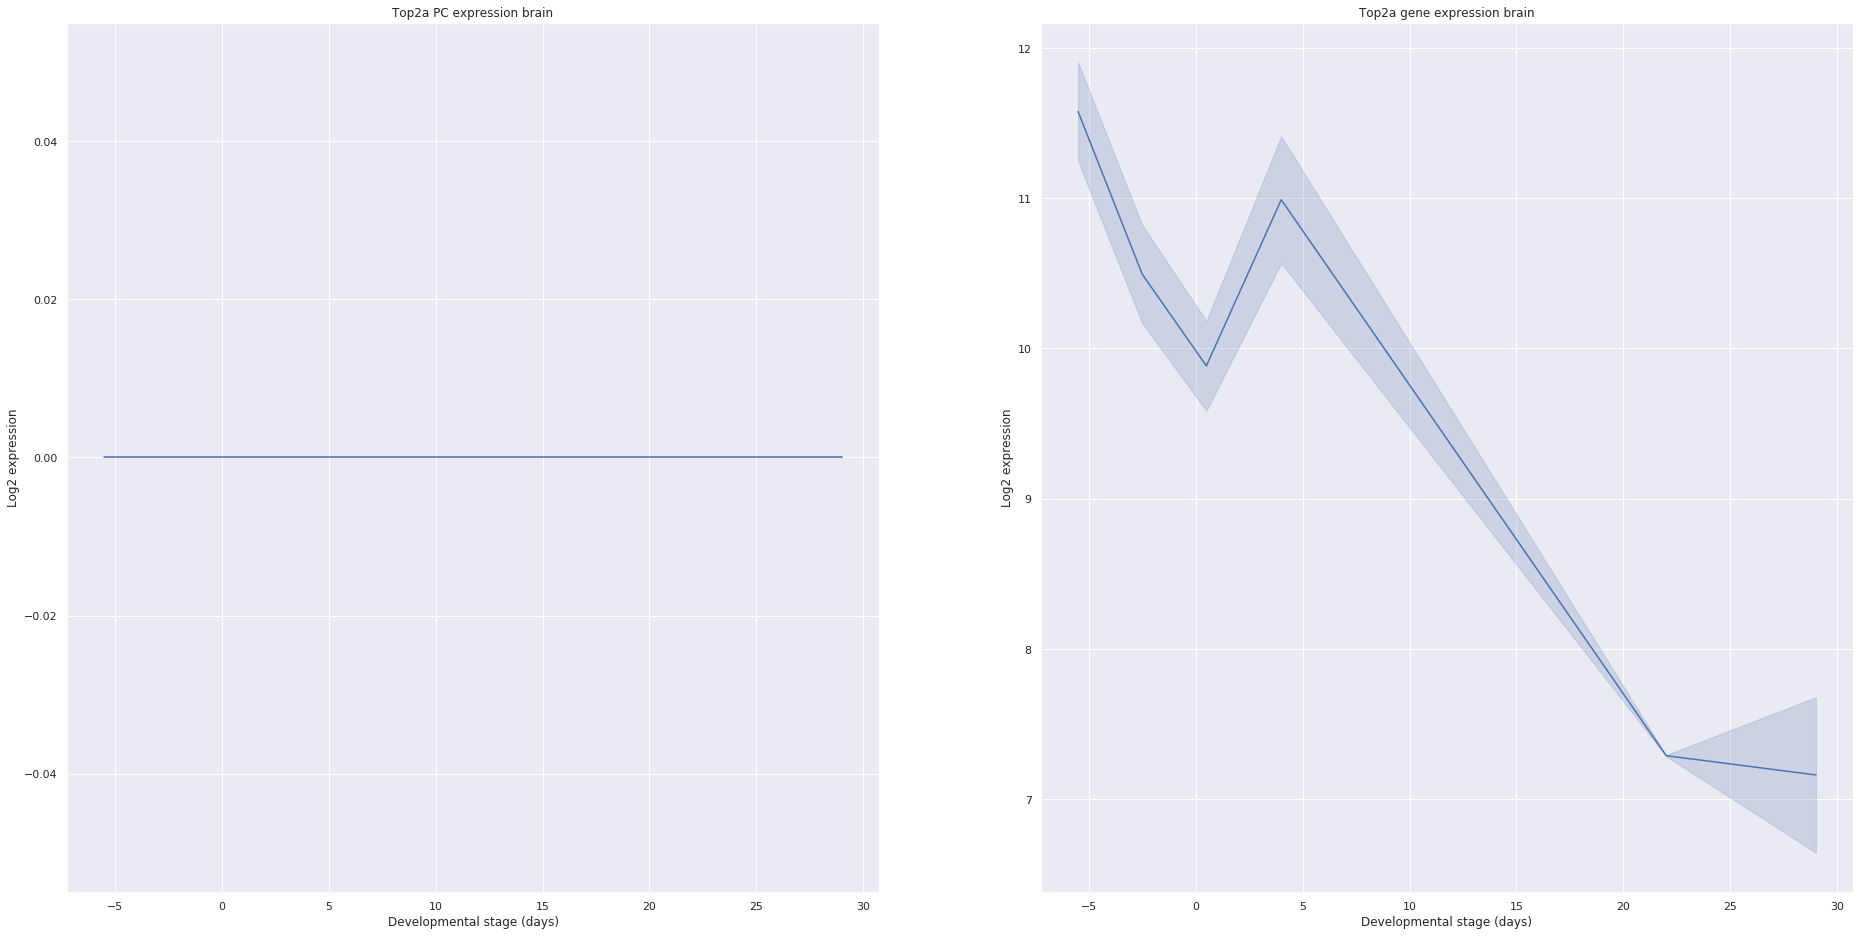

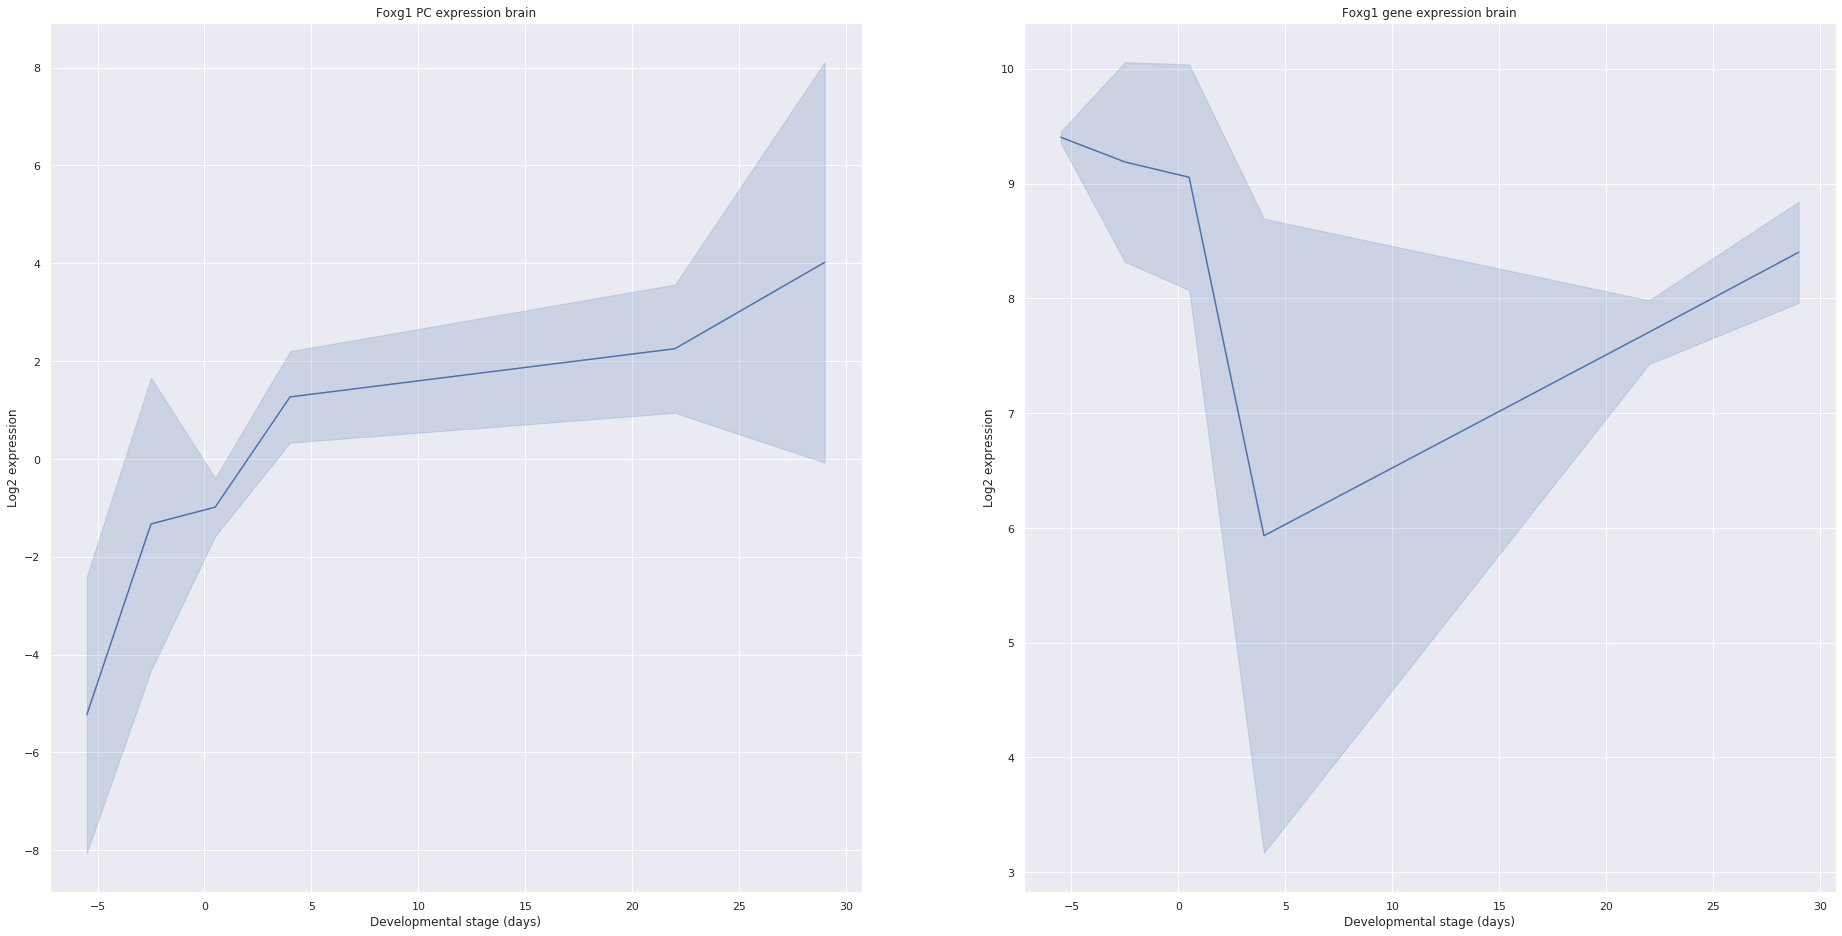

Gene contributions for TF Klf9:


PC1 contribution  PC2 contribution
Txndc11               1.0               0.0
Cldn34d               0.0               1.0

1.0

Gene contributions for TF Sox11:


PC1 contribution  PC2 contribution
Ireb2        1.960608e-02      2.848046e-04
Cacybp       1.931732e-02      3.106994e-04
Arih1        1.866890e-02      1.363006e-03
Ddx5         1.807481e-02      5.510013e-05
Abl1         1.790744e-02      1.162885e-03
...                   ...               ...
Tgif1        2.010542e-04      1.825991e-02
Rfc3         3.911868e-05      3.084640e-02
Tes          2.115886e-05      3.005531e-02
Mcm7         7.023911e-06      3.046597e-02
Cldn34d      5.542474e-36      2.545240e-34

[99 rows x 2 columns]

0.016541327622178397

Gene contributions for TF Zfp57:


PC1 contribution  PC2 contribution
Aida             0.279105          0.000465
Txndc11          0.273618          0.000588
Brox             0.235460          0.074156
Dcdc2a           0.211501          0.092701
Greb1            0.000315          0.832089
Cldn34d          0.000000          0.000000

0.2736182420450564

Gene contributions for TF Top2a:


PC1 contribution
Cldn34d               1.0

Gene contributions for TF Foxg1:


PC1 contribution  PC2 contribution
Astn2                  0.061787          0.004283
Stat5a                 0.058338          0.000054
Aida                   0.057388          0.009220
Rnd2                   0.055179          0.008037
Erlec1                 0.053817          0.007366
Plekha7                0.052548          0.001698
Ncald                  0.052106          0.018508
Asb3                   0.050475          0.006204
Kcnip4                 0.048989          0.024411
6430548M08Rik          0.048637          0.026045
Btbd17                 0.048522          0.022568
Gltp                   0.045712          0.018685
Brox                   0.043635          0.017311
Rcan3                  0.041378          0.020175
Stk40                  0.039830          0.000048
Nkx2-2                 0.038025          0.015479
Lrrc36                 0.033787          0.005704
Asic1                  0.032583          0.034323
Lsm10                  0.025483          0.024809
Fam222a                0.025190          0.019343
Prlhr                  0.023526          0.001801
Tchp                   0.014862          0.070007
Nav2                   0.014788          0.057819
Runx1t1                0.010336          0.085269
Txnip                  0.006701          0.045044
Nfix                   0.006487          0.050862
Cdkn3                  0.003117          0.068976
Tfap4                  0.002705          0.094093
Ebf1                   0.002064          0.083563
Greb1                  0.001665          0.043365
Nyap1                  0.000291          0.076501
Kctd19                 0.000048          0.038427
Gpr142                 0.000000          0.000000
Nkx2-6                 0.000000          0.000000

In [207]:
[a,b,c] = main2(10,700,100,n_pc=2,PC=1,organ='brain')

In [14]:
DICT = Bigdict(10)
for MACS2 in [300,500,700]:
    for MAX in [100,300,500]:
        TF_targets_dict(DICT,MACS2,MAX,10)

Genes for Acaa2 (0) found
Genes for Acss2 (1) found
Genes for Actb (2) found
Genes for Adnp (3) found
Genes for Aebp2 (4) found
Genes for Aff3 (5) found
Genes for Aff4 (6) found
Genes for Ahcy (7) found
Genes for Ahr (8) found
Genes for Aicda (9) found
Genes for Aire (10) found
Genes for Anp32e (11) found
Genes for Ar (12) found
Genes for Arid1a (13) found
Genes for Arid3a (14) found
Genes for Arid4b (15) found
Genes for Arntl (16) found
Genes for Art1 (17) found
Genes for Ascl1 (18) found
Genes for Ascl2 (19) found
Genes for Ash1l (20) found
Genes for Ash2l (21) found
Genes for Asxl1 (22) found
Genes for Atf2 (23) found
Genes for Atf3 (24) found
Genes for Atf4 (25) found
Genes for Atf7 (26) found
Genes for Atf7ip (27) found
Genes for Atm (28) found
Genes for Atoh1 (29) found
Genes for Atrx (30) found
Genes for Auts2 (31) found
Genes for Bach1 (32) found
Genes for Bach2 (33) found
Genes for Bap1 (34) found
Genes for Batf (35) found
Genes for Batf3 (36) found
Genes for Baz1a (37) found


Genes for Lmnb1 (300) found
Genes for Lmo2 (301) found
Genes for Lmx1b (302) found
Genes for Lrrfip1 (303) found
Genes for Lyl1 (304) found
Genes for Maf (305) found
Genes for Mafa (306) found
Genes for Mafb (307) found
Genes for Maff (308) found
Genes for Mafg (309) found
Genes for Mafk (310) found
Genes for Mapk8 (311) found
Genes for Max (312) found
Genes for Maz (313) found
Genes for Mbd1 (314) found
Genes for Mbd2 (315) found
Genes for Mbd3 (316) found
Genes for Mcrs1 (317) found
Genes for Mecp2 (318) found
Genes for Med1 (319) found
Genes for Med12 (320) found
Genes for Med23 (321) found
Genes for Med24 (322) found
Genes for Med26 (323) found
Genes for Mef2a (324) found
Genes for Mef2c (325) found
Genes for Mef2d (326) found
Genes for Meis1 (327) found
Genes for Men1 (328) found
Genes for Mettl3 (329) found
Genes for Mitf (330) found
Genes for Mllt3 (331) found
Genes for Mnx1 (332) found
Genes for Morc3 (333) found
Genes for Mphosph8 (334) found
Genes for Mpnd (335) found
Genes f

Genes for Taf2 (595) found
Genes for Taf3 (596) found
Genes for Taf7l (597) found
Genes for Taf9b (598) found
Genes for Tal1 (599) found
Genes for Tbl1x (600) found
Genes for Tbp (601) found
Genes for Tbpl1 (602) found
Genes for Tbr1 (603) found
Genes for Tbx19 (604) found
Genes for Tbx20 (605) found
Genes for Tbx21 (606) found
Genes for Tbx3 (607) found
Genes for Tbx4 (608) found
Genes for Tbx5 (609) found
Genes for Tcea1 (610) found
Genes for Tcf12 (611) found
Genes for Tcf3 (612) found
Genes for Tcf4 (613) found
Genes for Tcf7 (614) found
Genes for Tcf7l1 (615) found
Genes for Tcf7l2 (616) found
Genes for Tdg (617) found
Genes for Tead1 (618) found
Genes for Tead2 (619) found
Genes for Tead4 (620) found
Genes for Terf1 (621) found
Genes for Terf2ip (622) found
Genes for Tet1 (623) found
Genes for Tet2 (624) found
Genes for Tet3 (625) found
Genes for Tfam (626) found
Genes for Tfap2a (627) found
Genes for Tfap2c (628) found
Genes for Tfap4 (629) found
Genes for Tfcp2l1 (630) found
Ge

In [29]:
def heatmap(PCAdata, expdata, TF_gene_sets):
    '''
    Experimental function that for a specific TF is supposed to create a heatmap describing how the transcription
    of all genes in the gene set has changed over time, as well as how the PC 'activity changes over time so the 
    two can be compared visually.
    '''
    TF = TF_gene_sets.index[25] 
    genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
    genesIndex.set_index('Genes', inplace=True)  
    genes = genesIndex.index.intersection(expdata.index)
    TFdata = expdata.loc[genes,'liver']
    PCA = pd.DataFrame(PCAdata.loc['liver',TF])
    x = TFdata.shape[0]
    fig, (ax0,ax1) = plt.subplots(2,1, sharex=True, figsize=(8,1+x), gridspec_kw={'height_ratios': [1,x]})
    g1 = sns.heatmap(PCA.T, cbar=False, ax=ax0, square=True, linewidths=1, linecolor='black')
    g2 = sns.heatmap(TFdata, cbar=False, ax=ax1, square=True, linewidths=1, linecolor='black')
    ax0.set_xlabel('')
    fig.tight_layout()
    
def expmean(expdata):
    
    means = []
    means.append(expdata.loc[:,'-5'].mean())
    means = pd.DataFrame(index=expdata.columns)
    
    
def genesethist(df, xlim=500):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets
    '''
    print('Dataset contains '+str(df.shape[0])+' TFs')
    print('Dataset contains '+str(df.loc[df['Gene count'] == 1].shape[0])+' TF(s) with only a single gene')
    bins = np.linspace(0,xlim, 51)
    plt.figure(figsize=(16,8))
    plt.xlabel('Number of genes')
    plt.ylabel('Numberr of TFs')
    axes = plt.gca()
    axes.set_xlim([0,xlim])
    plt.hist(df.loc[:,'Gene count'], bins)
    
    plt.show()

def fewgenesethist(df):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets with 500 or fewer genes
    '''
    bins = np.linspace(0,500, 51)
    plt.figure(figsize=(16,8))
    plt.hist(df.loc[:,'Gene count'], bins)
    axes = plt.gca()
    axes.set_xlim([0,500])
    plt.xlabel('Number of genes')
    plt.ylabel('Number of TFs')
    plt.xlim=[0,500]
    print('Dataset contains '+str(df.loc[df['Gene count'] <= 500].shape[0])+' TF(s) with 500 or fewer genes')
    plt.show()
    
def varexplplot(df,PC=1, xlim=500):
    '''
    Function to plot the variance explained by the first PC against nr of genes in the gene set
    '''
    plt.figure(figsize=(16,8))
    plot = sns.scatterplot(x='Gene count', y='Variance explained PC'+str(PC), data=df, s=20)
    plot.set(ylim=(0,1))
    plot.set(xlim=(0,xlim))
    plt.xlabel('Number of genes')
    plt.show()
#    save_fig(plt,'Variance',str(xlim))
    
def varregplot(df):
    df = df.loc[df['Gene count']>=100]
    plt.figure(figsize=(16,8))
    plot = sns.regplot(x='Gene count', y='Variance explained PC1', data=df, scatter_kws={'s':2})
    plot.set(ylim=(0,1))
    plot.set(xlim=(100,16000))
    plt.xlabel('Number of genes')
    plt.title('Linear regression for TFs with >=100 genes')
    plt.show()
    
def PCplot(dfs, hue='organ', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def PCplot2(dfs, hue='stage', ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    PCS.set_index('organ', inplace=True)
    PCSl = PCS.loc['liver',:]
    PCSb = PCS.loc['brain',:]
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=2.7,rot=0.1,dark=0.4,light=0.8', data=PCSb, legend='full', ax=ax)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=1.7,rot=0.1,dark=0.4,light=0.8', data=PCSl, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot

def PCplot3(dfs, hue='stage', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,stage], axis=1)
    PCS.columns = ['PC1','PC2','stage']
    display(PCS)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def datacheck(kbp, MACS2, MAX, organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp, MACS2, MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    TF_gene_sets.loc['All','Genes'] = list(logdata.index[:])
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_per_TF, Other_results, Contributions] = run_my_pca(logdata, TF_gene_sets,Other_results,2)
    full = Other_results.loc['All',:]
    genesethist(Other_results.drop(['All']))
    fewgenesethist(Other_results.drop(['All']))
    print('The first PC from PCA for full genome with '+str(int(full['Gene count']))+' genes explained '+str(full['Variance explained PC1']*100)+'% of variance in the full dataset.')
    varexplplot(Other_results.drop(['All']))
    #    varregplot(Other_results.drop(['All']))
    PCplot(PCA_per_TF)
    PCplot2(PCA_per_TF)

    return TF_gene_sets, Contributions

def datacheck2(kbp, MACS2, MAX, organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp, MACS2, MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    display(expdata)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_results, Other_results, Contributions] = run_my_pca(logdata,TF_gene_sets,Other_results, n_pc=2)

    genesethist(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX, PC=2)

    if organ == None:
        fig, axes = plt.subplots(1,2, figsize=(32,16))
        PCplot(PCA_results, ax=axes[0])
        PCplot2(PCA_results, ax=axes[1])
    else:
        PCplot3(PCA_results)

    return TF_gene_sets, Contributions

def PCcheck(kbp, MACS2, genelim, organ=None):
    TF_gene_sets = gene_sets(kbp, MACS2)
    TF_gene_sets_res = TF_gene_sets.copy()
    for TF in TF_gene_sets_res.index:
        if len(TF_gene_sets_res.loc[TF,:][0])>genelim or len(TF_gene_sets_res.loc[TF,:][0])<2:
            TF_gene_sets_res.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]

    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    Other_results_res = pd.DataFrame(index=TF_gene_sets_res.index)

    [PCA_per_TF, Other_results, Contributions] = run_my_pca(logdata, TF_gene_sets,Other_results,2)
    [PCA_per_TF_res, Other_results_res, Contributions_res] = run_my_pca(logdata, TF_gene_sets_res,Other_results_res,2)
    fig, axes = plt.subplots(2,2, figsize=(32,32)) #, gridspec_kw={'height_ratios': [1,x]})
    
    PCplot(PCA_per_TF, ax=axes[0,0])
    PCplot2(PCA_per_TF, ax=axes[0,1])
    PCplot(PCA_per_TF_res, ax=axes[1,0])
    PCplot2(PCA_per_TF_res, ax=axes[1,1])
    plt.show()
    #save_fig(fig,'PC','check')

def checkdatacheck():
    data = pd.DataFrame()
    for i in range(300,1200,100):
        TF_gene_sets = gene_sets(10,i)
        length = pd.DataFrame(index=TF_gene_sets.index, columns=['Genes'])
        for TF in TF_gene_sets.index:
            length.loc[TF:,'Genes'] = len(TF_gene_sets.loc[TF,:][0])
        data.loc[i,'TFs'] = length.shape[0]
        data.loc[i,'TFs 1-500'] = length.loc[length['Genes'] <= 500].shape[0]
        data.loc[i,'TFs 2-500'] = data.loc[i,'TFs 1-500']-length.loc[length['Genes'] == 1].shape[0]
    return data

def contplot():
    bins = np.linspace(0,max(cont.loc[:,'Contribution']), 50)
    plt.hist(cont.loc[:,'Contribution'], bins)#, , alpha=0.5, label=variable)
    plt.xlabel('% contribution to PC1')
    plt.ylabel('Nr of genes')
    plt.title(TF)
    plt.show()
    


organ        liver        brain         liver         brain        liver  \
dev_stage    -5.5   -5.5  -5.5  -5.5    -2.5    -2.5  -2.5  -2.5    0.5    
Symbol                                                                     
Gnai3         4800   1646  2510  1424    4779    3478  1694  2512   2481   
Pbsn             0      0     0     0       0       0     0     0      0   
Cdc45          984    337   163   108     549     490    63    90    420   
H19          77631  31553  4113  1862  182270  140922  1289  3352  79202   
Scml2           72     25    85    54      48      38    63   117     34   
...            ...    ...   ...   ...     ...     ...   ...   ...    ...   
Vmn1r-ps47       0      0     0     0       0       0     0     0      0   
Gm22396          0      0     0     0       0       0     0     0      0   
Gm22394          0      0     0     0       1       0     0     0      0   
Vmn1r-ps147      0      0     0     0       0       0     0     0      0   
Methig1          0      0     0     0       0       4     0     0      1   

organ               ... brain       liver       brain       liver       brain  \
dev_stage     0.5   ...  4.0   4.0   22.0  22.0  22.0  22.0  29.0  29.0  29.0   
Symbol              ...                                                         
Gnai3         1138  ...  2429  1502  2125  1974  1153  1409  1543  1470  1937   
Pbsn             0  ...     0     0     0     0     0     0     0     0     0   
Cdc45          202  ...    99   123    98   110    41    40    27    32    73   
H19          72111  ...   403   996  2219  2385    34    73   151    71    47   
Scml2           17  ...    92    63    17     5    13    17     6     2    26   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
Vmn1r-ps47       0  ...     0     0     0     0     0     0     0     0     0   
Gm22396          0  ...     0     0     0     0     0     0     0     0     0   
Gm22394          0  ...     0     0     0     0     0     0     0     0     0   
Vmn1r-ps147      0  ...     0     0     0     0     0     0     0     0     0   
Methig1          0  ...     0     0     0     0     0     0     0     0     0   

organ              
dev_stage    29.0  
Symbol             
Gnai3         856  
Pbsn            0  
Cdc45          29  
H19            29  
Scml2           9  
...           ...  
Vmn1r-ps47      0  
Gm22396         0  
Gm22394         0  
Vmn1r-ps147     0  
Methig1         0  

[32394 rows x 24 columns]

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


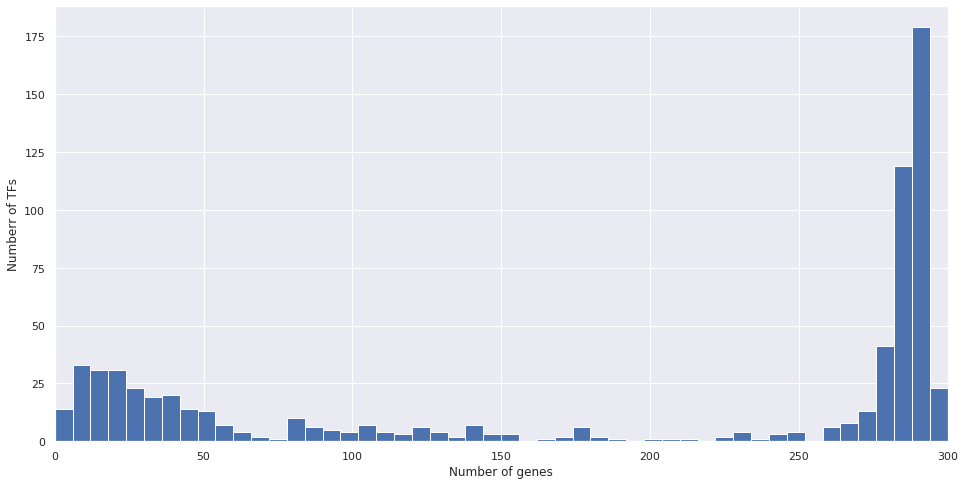

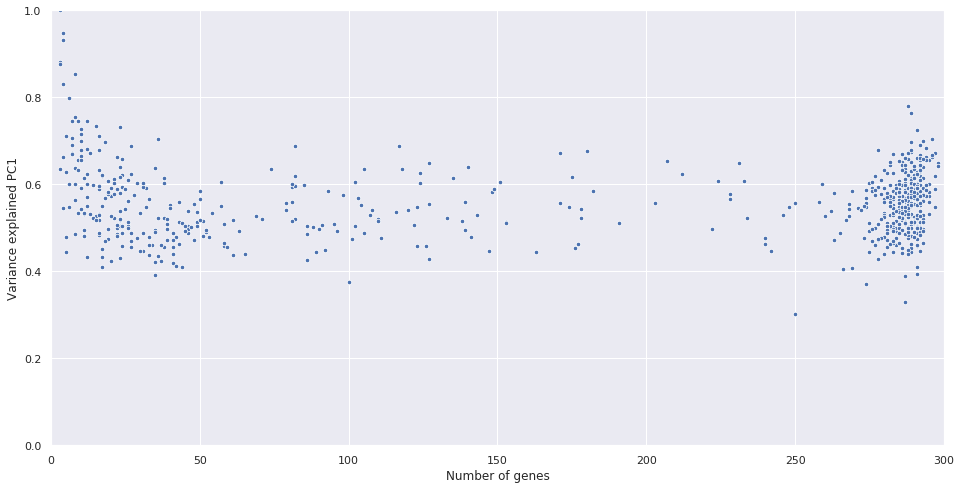

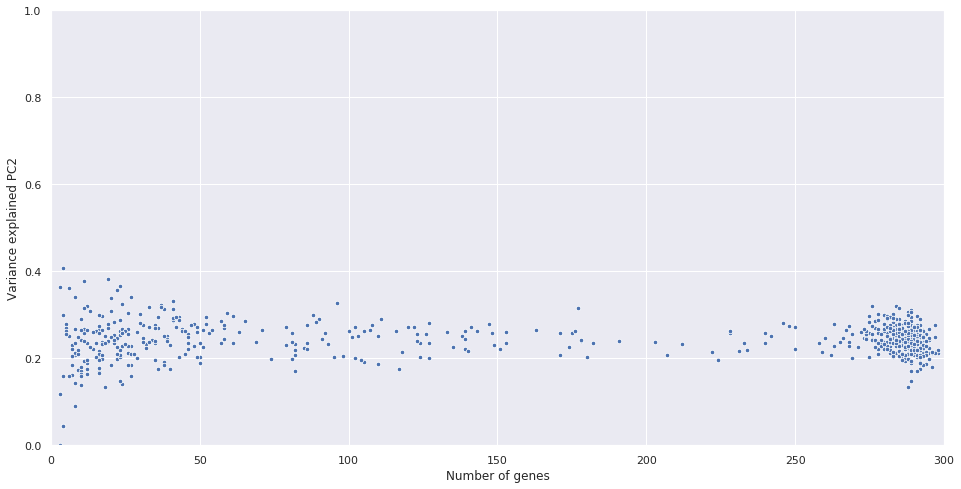

PC1       PC2  stage
0  -2.906529  0.704332   -5.5
1   0.932319  2.880924   -5.5
2  -2.137053  0.495952   -2.5
3  -1.434418  0.328252   -2.5
4  -1.196534 -0.592267    0.5
..       ...       ...    ...
7   0.366943 -0.171035    4.0
8  -0.366671  2.198302   22.0
9  -1.029158  3.446587   22.0
10 -1.976298  1.029578   29.0
11 -3.120863  1.985876   29.0

[8328 rows x 3 columns]

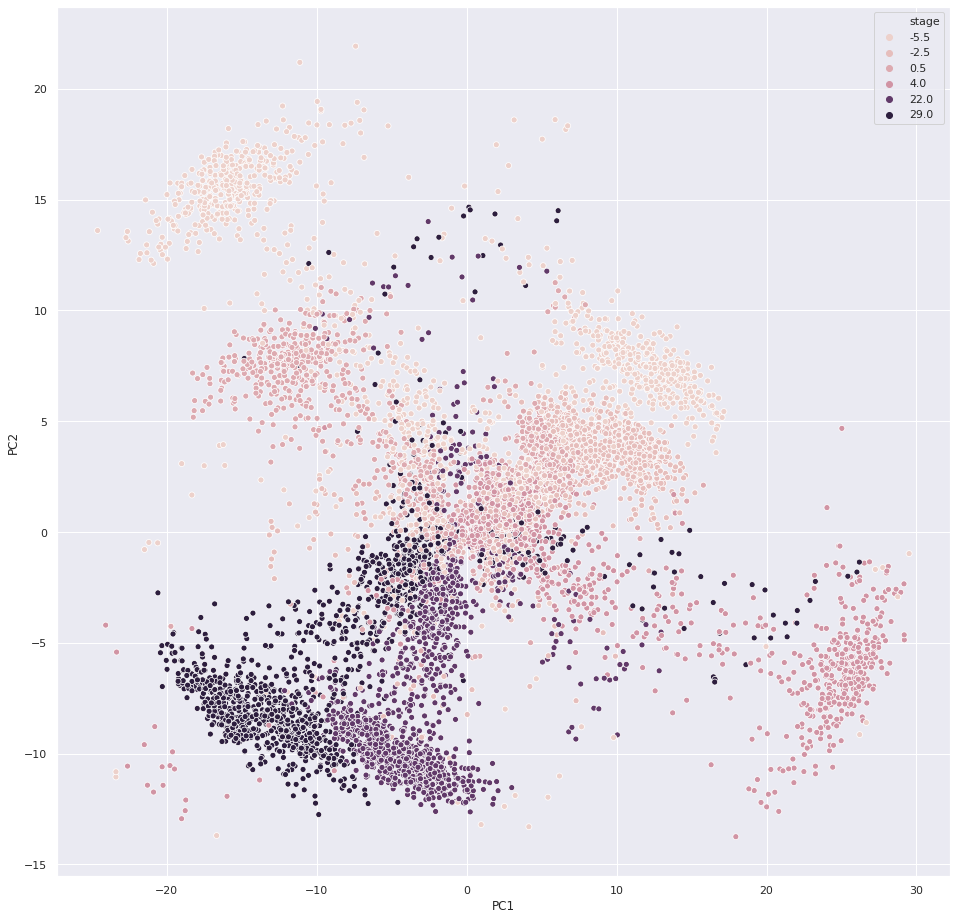

In [30]:
[a,b] = datacheck2(10,300,300,'liver')

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


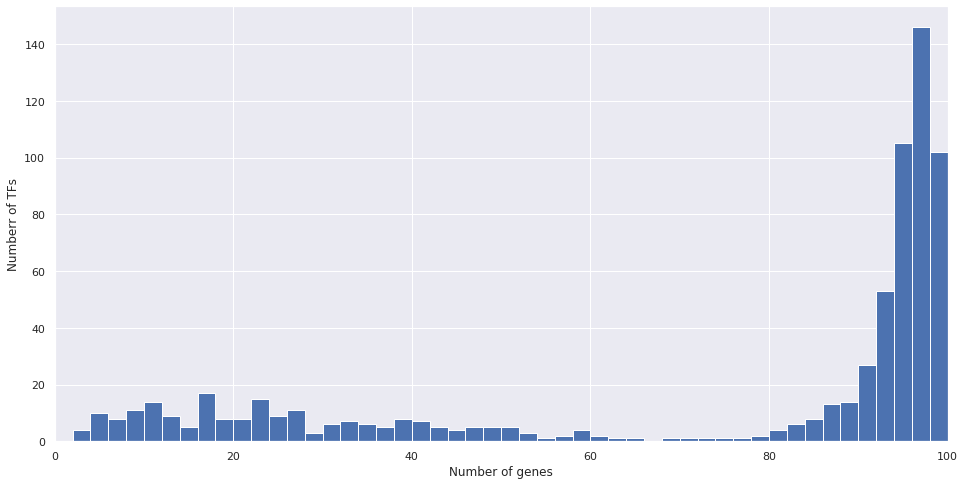

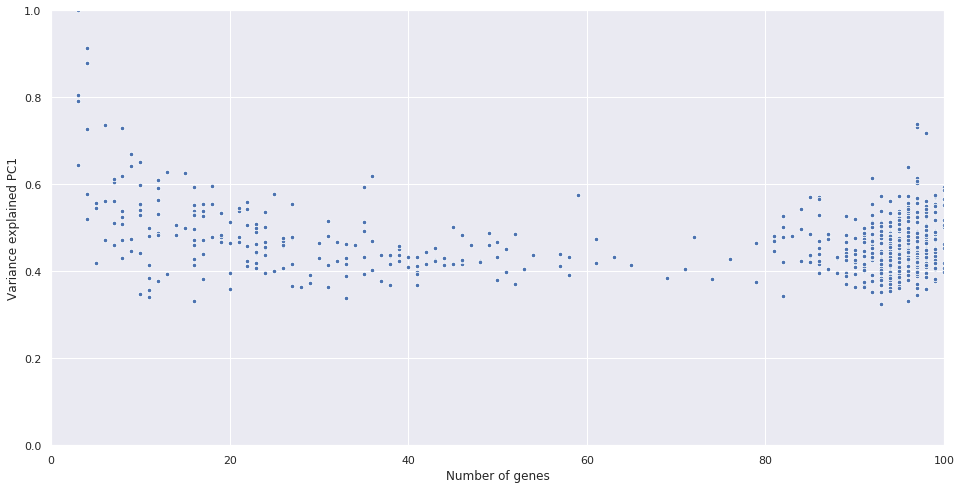

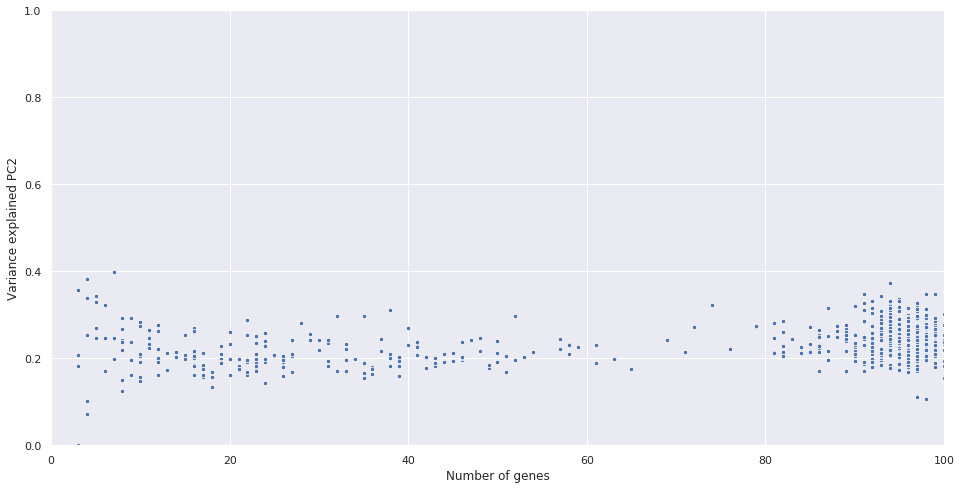

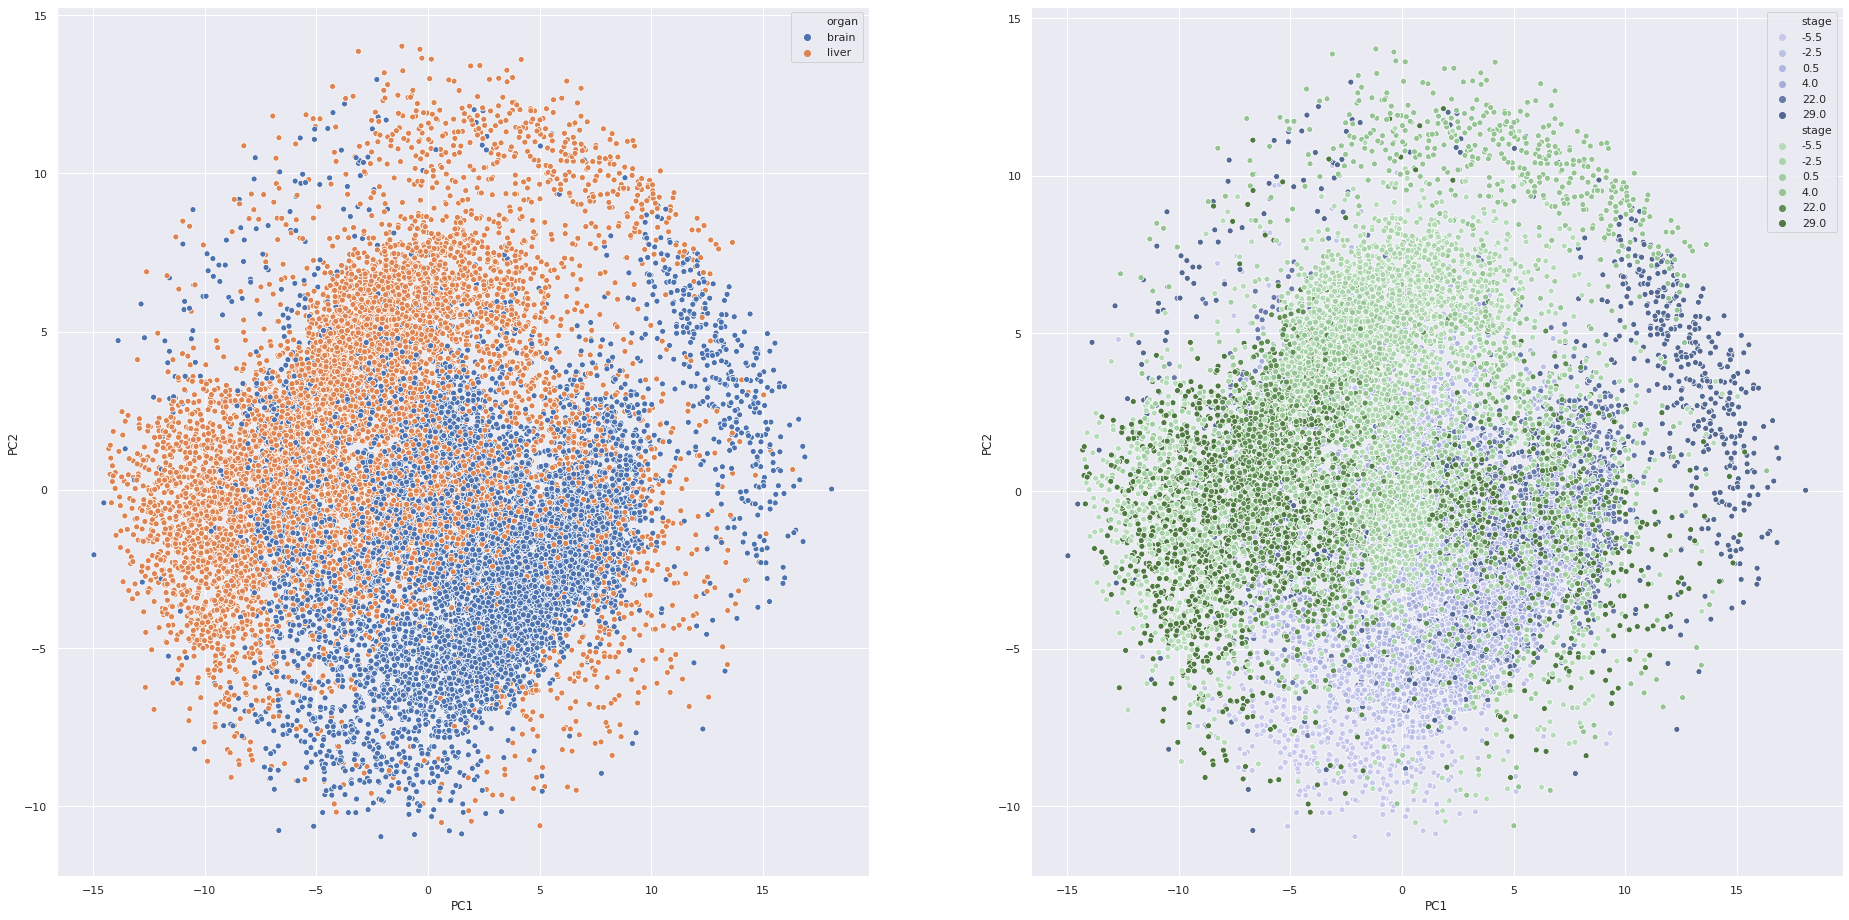

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [16]:
[a,b] = datacheck2(10,300,100)

Dataset contains 699 TFs
Dataset contains 0 TF(s) with only a single gene


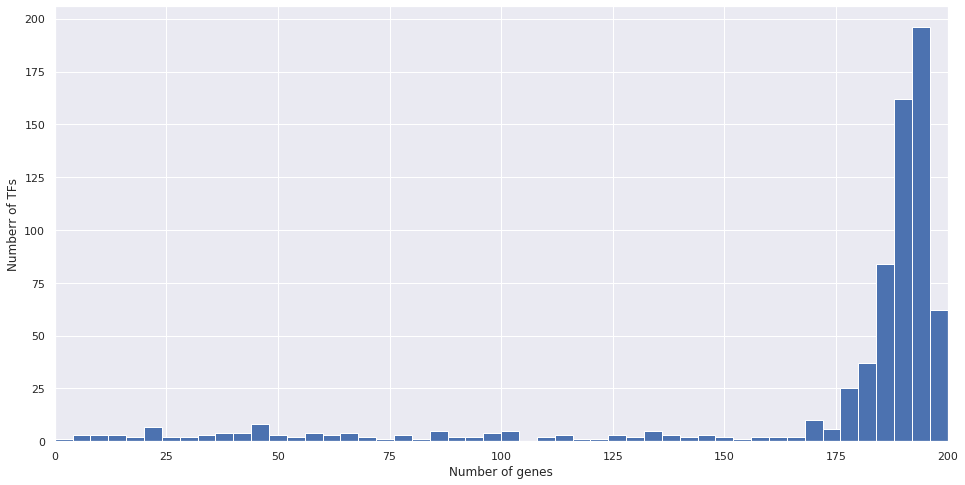

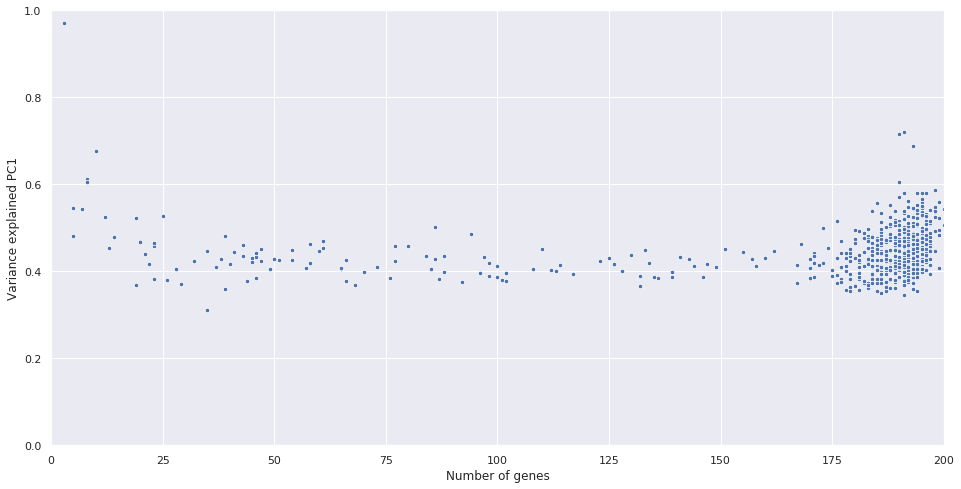

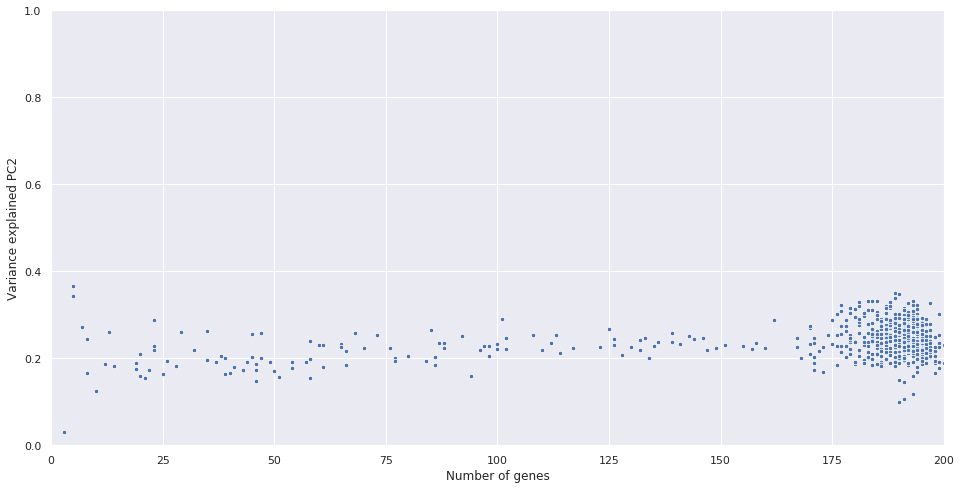

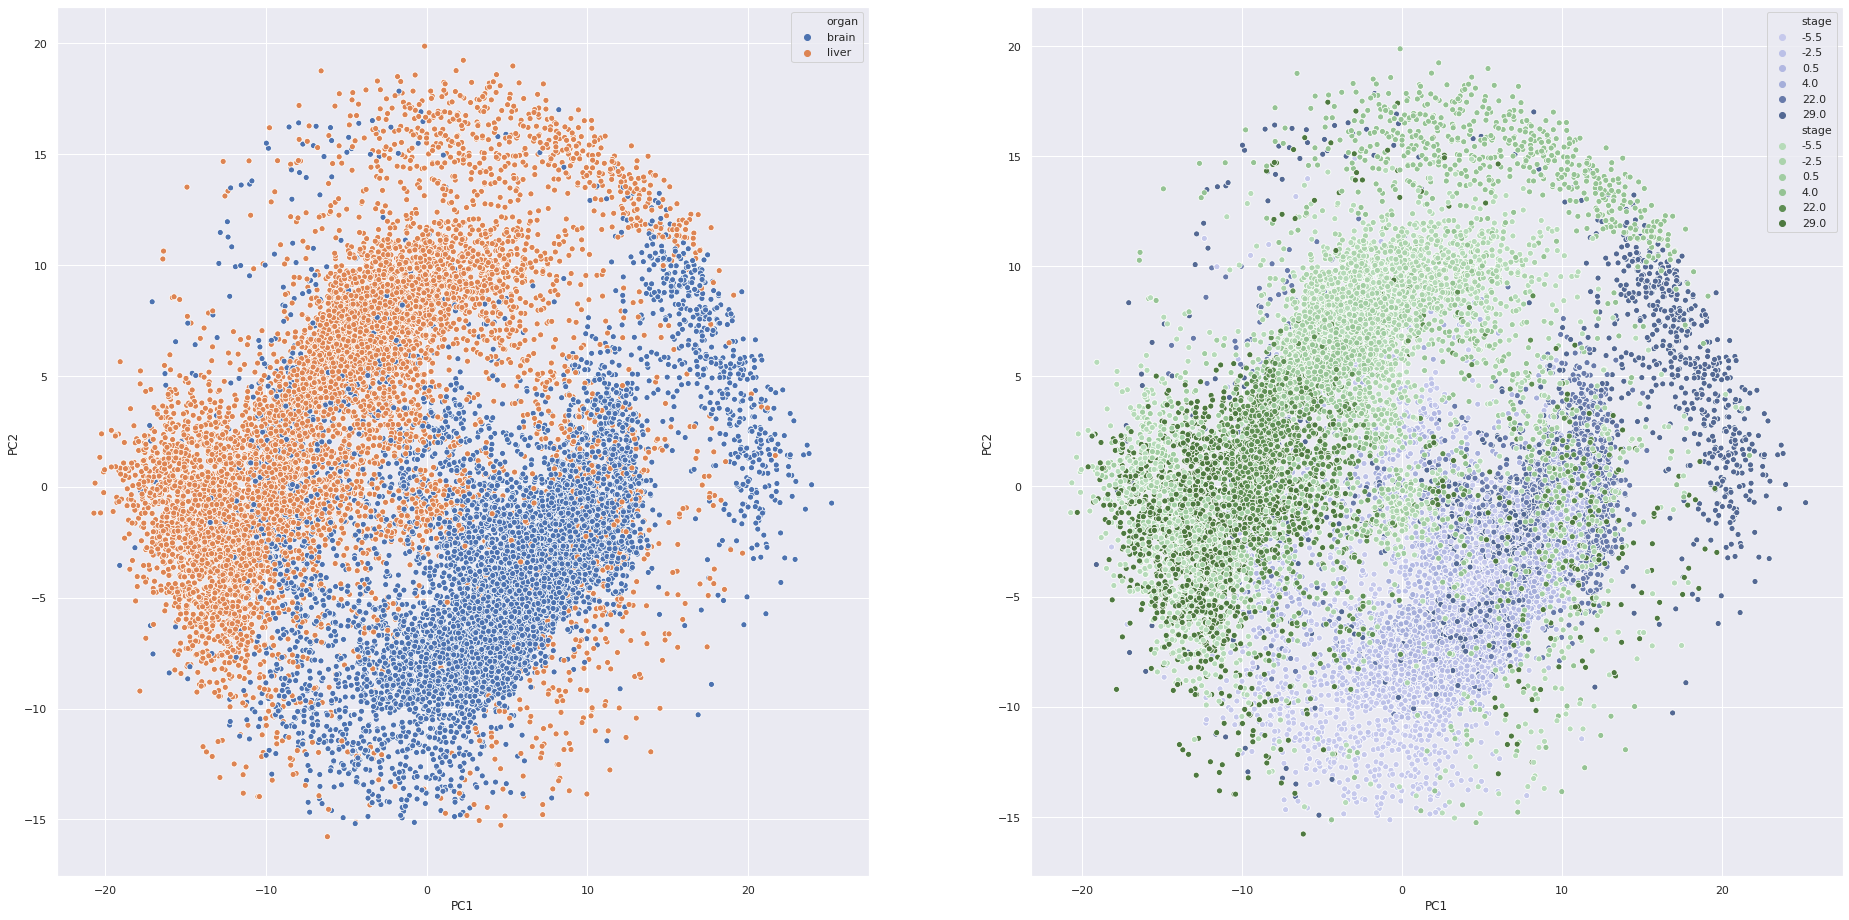

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [105]:
[res, cont] = datacheckTOP(10,200)

/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: Pe

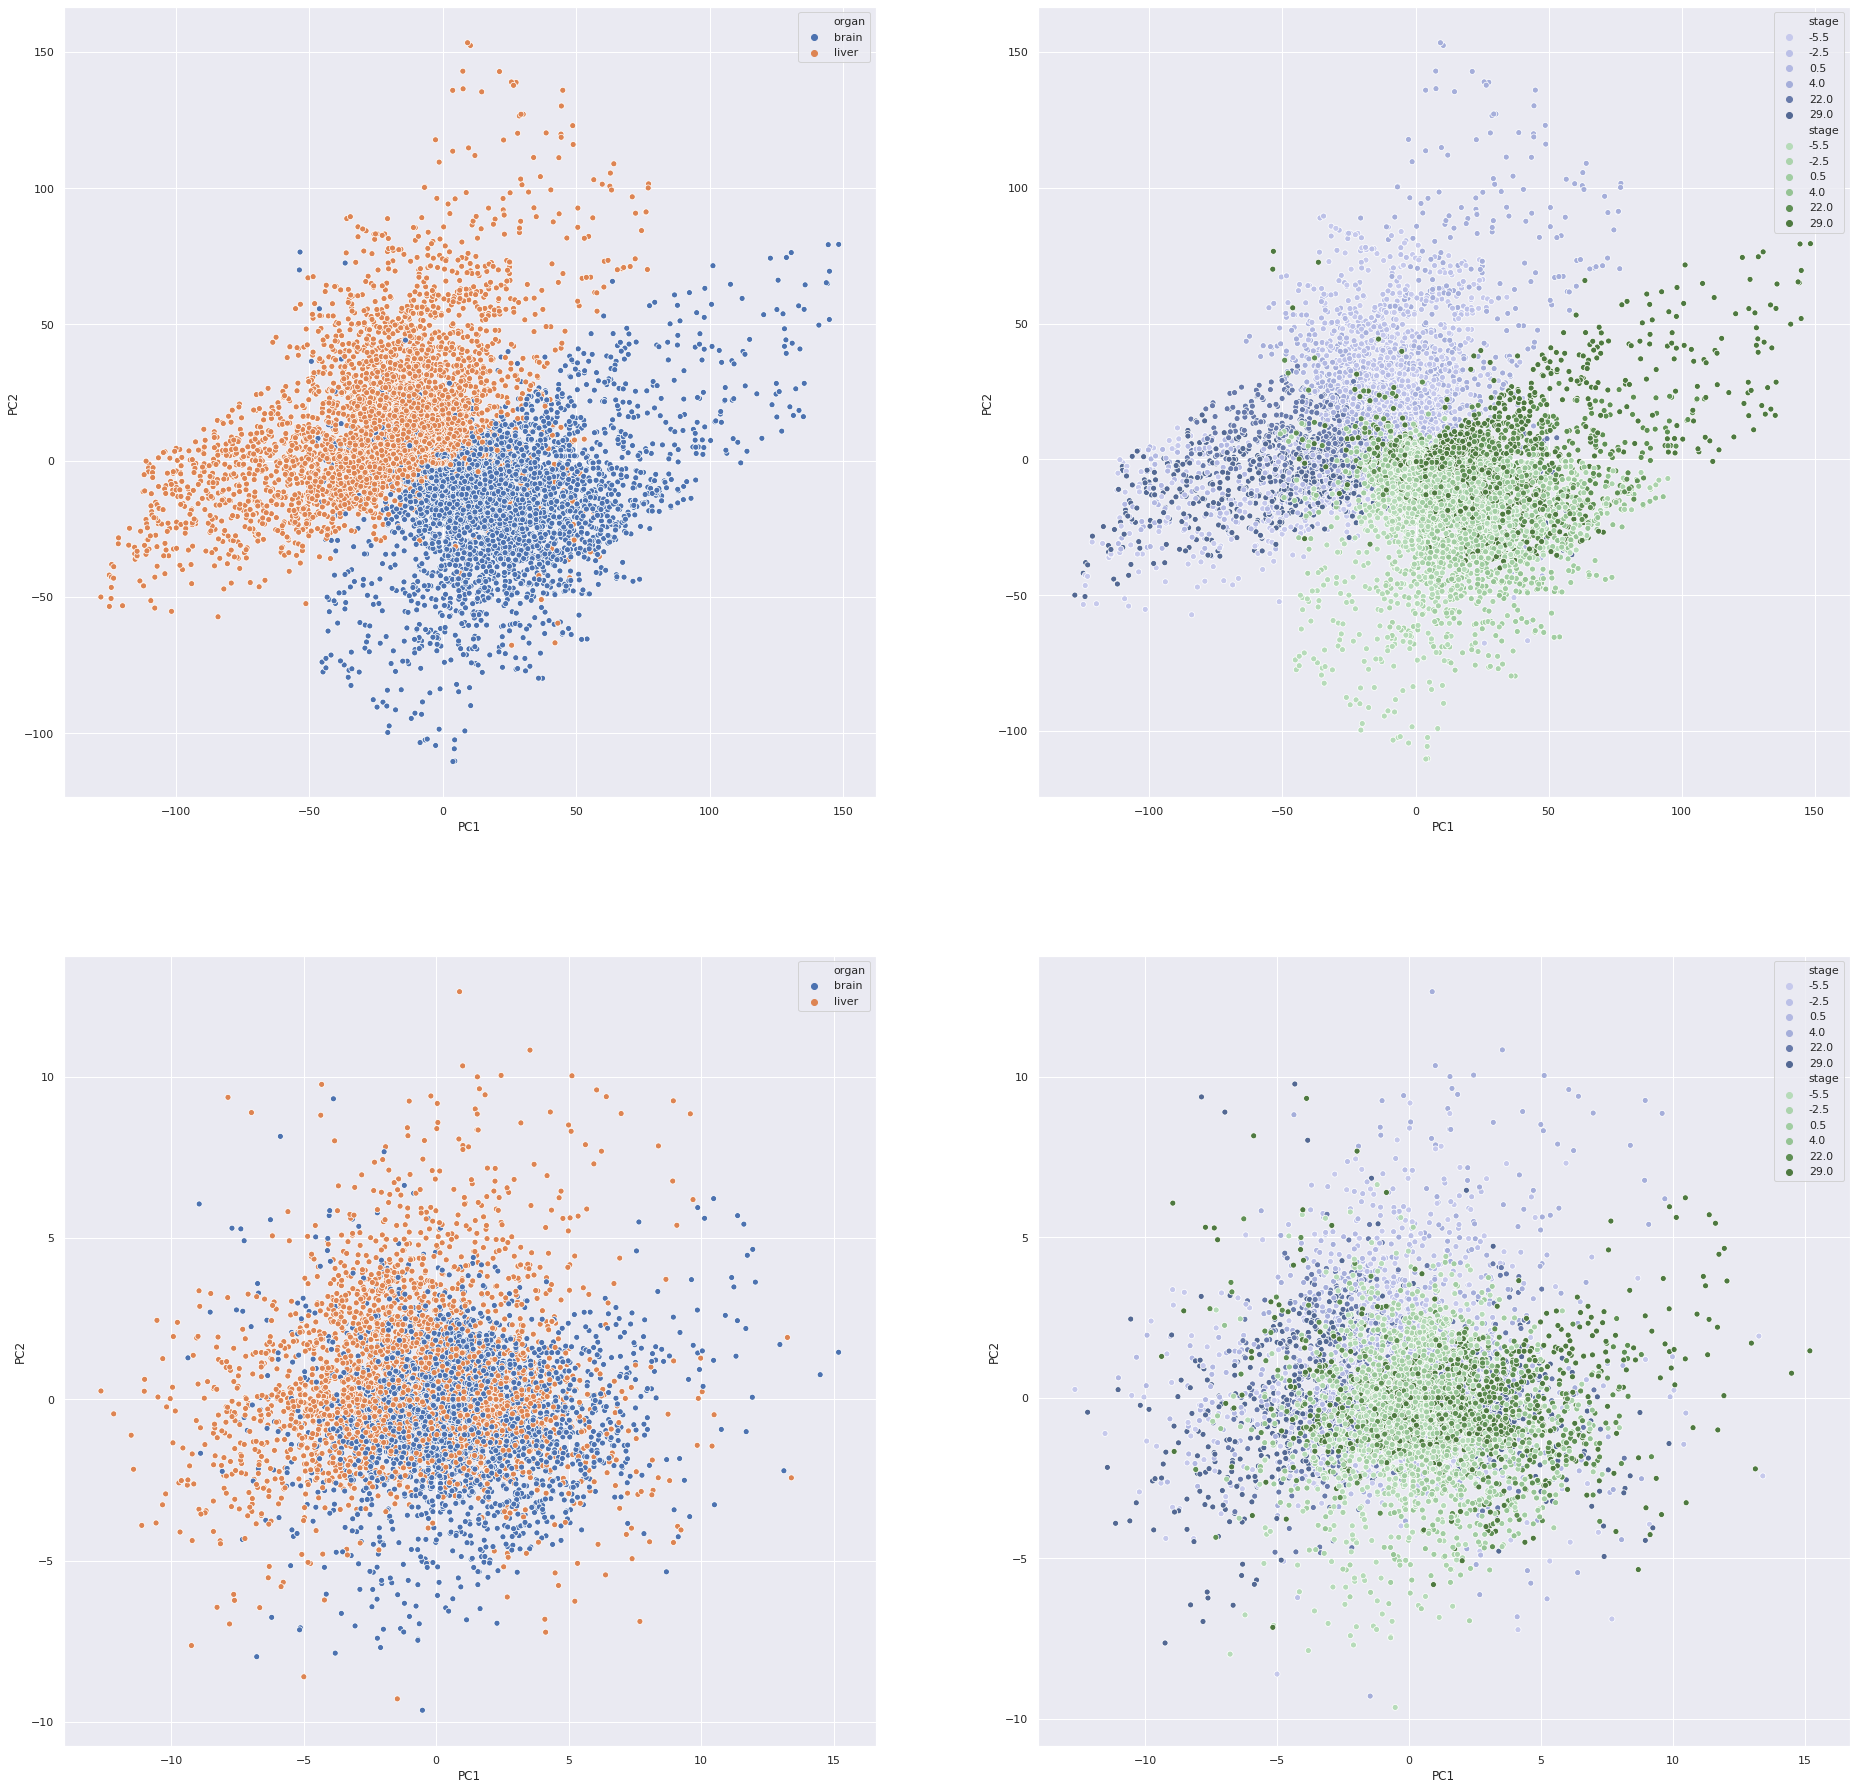

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [24]:
PCcheck(10,700,100)

## Old/unused code

In [8]:
def gene_sets_TOP(kbp, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_TOP(kbp, MAX, chip)
        
    return TF_gene_sets

def TFs_targets_strict(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = TF_gene_set.loc[(TF_gene_set > MACS2).sum(axis=1)>0,:].index.tolist() #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets


def TFs_targets_TOP(kbp, MAX, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts up to a specified number of genes into a
    list. MACS2 scores are averaged across each sample type and genes with the highest MACS2 score, 
    considering all sample types, are selected for the list. The list is then coverted to a dataframe as
    output.
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes').iloc[:,1:-1] #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)):
                    col[i] = col[i].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t')
    return TF_gene_sets

def main_porch(kbp, MACS2,genelim):
    '''
    Main function for running the primary experiment, but using porch
    '''
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    TF_gene_sets = gene_sets_porch (kbp, MACS2)
    for TF in TF_gene_sets.index:
        if len(TF_gene_sets.loc[TF,:][0])>genelim:
            TF_gene_sets.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    [PCA_results, untested] = porch(expdata, TF_gene_sets.reset_index(), gene_column='Genes', set_column='Antigen')

    return PCA_results, untested   

In [9]:
[test,test2] = main_porch(10,700,500)
display(test,test2)

Processing with 8 parallel processes
Decomposing Acaa2
Decomposing Ash1l


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Bcl11a


Decomposing Acss2
Decomposing Cbx1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Atf7
Decomposing Ddx5


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Actb
Decomposing Dnmt3b



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Bcor
Decomposing Cbx5


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Atf7ip


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Elk4


Decomposing Dgcr8


Decomposing Fosb
Decomposing Brca1
Decomposing Aff4


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Atm
Decomposing Ccnk
Decomposing Dpy30


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Ahcy



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Ell


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]




Decomposing Brd3


Decomposing Bap1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Foxa3
Decomposing Dicer1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Drosha
Decomposing Ccnt1


Decomposing Brd9


Decomposing Aicda


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Ell2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Baz1a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Foxk1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing E4f1
Decomposing Dlx1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Anp32e


Decomposing Brf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Chaf1b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Baz1b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Elob


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Eed


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Gad1
Decomposing Arid4b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Dlx3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Brf2


Decomposing Crx


Decomposing Baz2a
Decomposing Eomes


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Brwd1
Decomposing Ascl2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Gadd45a
Decomposing Dmap1


Decomposing Cry1


Decomposing Ehf


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Bbx


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Gckr



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Ercc3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Ehmt2
Decomposing Glis3



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Carm1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Gcm1
Decomposing Hexim1
Decomposing Cux2
Decomposing Dmrtb1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Gli1


Decomposing Elk1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Esrrg
Decomposing Ddit3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Hic2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Gli2




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Dnajc2
Decomposing Hoxc10
Decomposing Glyr1
Decomposing Etv2
Decomposing Elk3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Hira


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Dnmt3a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Gmnn


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]




Decomposing Hoxc6
Decomposing Jmjd1c
Decomposing Ezh1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Hmga2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Kdm5c



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Htatsf1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Mafg


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Grhl3
Decomposing Mphosph8



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Ncapg


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Jmjd6



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Htt


Decomposing Mapk8


Decomposing Hmgn2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Klf6


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Grip1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Mpnd


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Mbd1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Id2


Decomposing Kat2b
Decomposing Ncoa2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Hnrnpk


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Mta1
Decomposing Klf9


Decomposing Kdm2a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Mbd2




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Ikzf2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Ncoa3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing L3mbtl2



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Gtf2a2
Decomposing Hnrnpl


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Myo1c
Decomposing Med23


Decomposing Kdm3a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Ikzf3


Decomposing Hnrnpu


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Nfat5



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Myt1
Decomposing Mef2a



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Lef1


Decomposing Gtf2f1


Decomposing Hoxa11


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Kdm3b
Decomposing Ing1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Mllt3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Nfatc1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Naa10


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Lhx6





Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Irf7
Decomposing Hand1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Nr0b2
Decomposing Kdm4a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Nfkb1




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Mnx1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Nacc1


Decomposing Kdm4d


Decomposing Nkx3-2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Hells


Decomposing Lmnb1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Morc3
Decomposing Nr2f2
Decomposing Ovol2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Kdm5b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Nlrc5


Decomposing Nap1l1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Paf1


Decomposing Nr5a1
Decomposing Phc1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Nucks1
Decomposing Parp1
Decomposing Lmx1b
Decomposing Pou2f3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Nono
Decomposing Nbn
Decomposing Rarg


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Phf19
Decomposing Pax3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Nup153
Decomposing Rb1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Lrrfip1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Phf2
Decomposing Pbrm1


Decomposing Ruvbl2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Sirt7
Decomposing Prdm13


Decomposing Nup98


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Phf5a
Decomposing Rbbp4


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Pcgf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Sox10
Decomposing Sap18


Decomposing Six1
Decomposing Obox1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Smad6
Decomposing Rbbp5


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Pcgf3




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Phf6


Decomposing Prdm14


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Sox13


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Smarcad1


Decomposing Ogdh



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Pcgf5
Decomposing Satb2
Decomposing Rcor2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Phrf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Pcna


Decomposing Ogt


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Prm1


Decomposing Sox30



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Scml2



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Relb
Decomposing Smarcc1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Plagl1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Setd2


Decomposing Srsf2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Pml
Decomposing Sox5


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Smarcd1
Decomposing Prmt5
Decomposing Rif1
Decomposing Tbx3


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Ssrp1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Smc5
Decomposing Sfmbt1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Rtf1
Decomposing Sox6




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Pou2af1
Decomposing Psip1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (b

Decomposing Supt16
Decomposing Smchd1
Decomposing Sfmbt2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Sp7
Decomposing Tbx4



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Pwp1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Suv39h1



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Shox2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Tgif2
Decomposing Snai1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Tcea1


Decomposing Ruvbl1
Decomposing Spen


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brai

Decomposing Raf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Tdg


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Suv39h2
Decomposing Thap11


Decomposing Srebf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Tox


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Tead2
Decomposing Thra


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Sin3b


Decomposing Taf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Wdr61



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Srsf1




Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Tsc22d3
Decomposing Rai1


Decomposing Thrb
Decomposing Terf1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (bra

Decomposing Twist1





Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Zfp64
Decomposing Yap1


Decomposing Taf10
Decomposing Terf2ip


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Yeats4


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain

Decomposing Zfp708
Decomposing Tfam


Decomposing Uhrf1


Decomposing Tle1
Decomposing Taf9b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Yy2
Decomposing Zic1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Tfcp2l1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Tlx1


Decomposing Usp16


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Tbl1x


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Zmynd8


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]



Decomposing Zbtb24
Decomposing Top1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Usp7



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Zscan5b



Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

Decomposing Zc3h10


Decomposing Top2a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Vsx2


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Top2b


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Was


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Zeb1


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Wdr11


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Zfp322a


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]
Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Decomposing Zfp335


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]


Empty DataFrame
Columns: [(liver, -5.5), (liver, -5.5), (brain, -5.5), (brain, -5.5), (liver, -2.5), (liver, -2.5), (brain, -2.5), (brain, -2.5), (liver, 0.5), (liver, 0.5), (brain, 0.5), (brain, 0.5), (liver, 4.0), (liver, 4.0), (brain, 4.0), (brain, 4.0), (liver, 22.0), (liver, 22.0), (brain, 22.0), (brain, 22.0), (liver, 29.0), (liver, 29.0), (brain, 29.0), (brain, 29.0)]
Index: []

[0 rows x 24 columns]

['Acaa2',
 'Acss2',
 'Actb',
 'Aff4',
 'Ahcy',
 'Aicda',
 'Anp32e',
 'Arid4b',
 'Ascl2',
 'Ash1l',
 'Atf7',
 'Atf7ip',
 'Atm',
 'Bap1',
 'Baz1a',
 'Baz1b',
 'Baz2a',
 'Bbx',
 'Bcl11a',
 'Bcor',
 'Brca1',
 'Brd3',
 'Brd9',
 'Brf1',
 'Brf2',
 'Brwd1',
 'Carm1',
 'Cbx1',
 'Cbx5',
 'Ccnk',
 'Ccnt1',
 'Chaf1b',
 'Crx',
 'Cry1',
 'Cux2',
 'Ddit3',
 'Ddx5',
 'Dgcr8',
 'Dicer1',
 'Dlx1',
 'Dlx3',
 'Dmap1',
 'Dmrtb1',
 'Dnajc2',
 'Dnmt3a',
 'Dnmt3b',
 'Dpy30',
 'Drosha',
 'E4f1',
 'Eed',
 'Ehf',
 'Ehmt2',
 'Elk1',
 'Elk3',
 'Elk4',
 'Ell',
 'Ell2',
 'Elob',
 'Eomes',
 'Ercc3',
 'Esrrg',
 'Etv2',
 'Ezh1',
 'Fosb',
 'Foxa3',
 'Foxk1',
 'Gad1',
 'Gadd45a',
 'Gckr',
 'Gcm1',
 'Gli1',
 'Gli2',
 'Glis3',
 'Glyr1',
 'Gmnn',
 'Grhl3',
 'Grip1',
 'Gtf2a2',
 'Gtf2f1',
 'Hand1',
 'Hells',
 'Hexim1',
 'Hic2',
 'Hira',
 'Hmga2',
 'Hmgn2',
 'Hnrnpk',
 'Hnrnpl',
 'Hnrnpu',
 'Hoxa11',
 'Hoxc10',
 'Hoxc6',
 'Htatsf1',
 'Htt',
 'Id2',
 'Ikzf2',
 'Ikzf3',
 'Ing1',
 'Irf7',
 'Jmjd1c',
 'Jmjd6',
 'Kat2b',
 'Kdm2a',